Christopher Moore  
CSE 625 Project 2  
07/16/2023

In [1]:
using Base.Threads, Folds, ChunkSplitters
using BenchmarkTools
using Plots, ColorSchemes

# 1. Sinx Optimizations

In [2]:
@inline function seq_sinx(x::AbstractRange, n::Integer, degree::Bool)
    if degree x *= π/180 end
    result = fill(0f0, length(x))
    @inbounds for i in eachindex(x)
        @inbounds for n=0:n-1
            result[i] += (-1)^n * x[i]^(2n+1) / factorial(big(2n+1))
        end 
    end
    return result
end

seq_sinx (generic function with 1 method)

In [3]:
@inline function seq_simd_sinx(x::AbstractRange, n::Integer, degree::Bool)
    if degree x *= π/180 end
    result = fill(0f0, length(x))
    @inbounds for i in eachindex(x)
        @inbounds @simd for n=0:n-1
            result[i] += (-1)^n * x[i]^(2n+1) / factorial(big(2n+1))
        end 
    end
    return result
end

seq_simd_sinx (generic function with 1 method)

In [4]:
@inline function thread_sinx(x::AbstractRange, n::Integer, degree::Bool)
    if degree x *= π/180 end
    result = fill(0f0, length(x))
    @inbounds @threads for i in eachindex(x)
        @inbounds for n=0:n-1
            result[i] += (-1)^n * x[i]^(2n+1) / factorial(big(2n+1))
        end
    end
    return result
end

thread_sinx (generic function with 1 method)

In [5]:
@inline function thread_simd_sinx(x::AbstractRange, n::Integer, degree::Bool)
    if degree x *= π/180 end
    result = fill(0f0, length(x))
    @inbounds @threads for i in eachindex(x)
        @inbounds @simd for n=0:n-1
            result[i] += (-1)^n * x[i]^(2n+1) / factorial(big(2n+1))
        end 
    end
    return result
end

thread_simd_sinx (generic function with 1 method)

In [6]:
A = 1:0.001:90; N = 1000
print("seq_sinx         "); @time seq_sinx(A, N, true)
print("seq_simd_sinx    "); @time seq_simd_sinx(A, N, true)
print("thread_sinx      "); @time thread_sinx(A, N, true)
print("thread_simd_sinx "); @time thread_simd_sinx(A, N, true)
println()

seq_sinx         436.700514 seconds (1.38 G allocations: 132.388 GiB, 1.80% gc time, 0.01% compilation time)
seq_simd_sinx    433.560515 seconds (1.38 G allocations: 132.387 GiB, 1.78% gc time, 0.00% compilation time)
thread_sinx       71.633019 seconds (1.98 G allocations: 141.318 GiB, 14.86% gc time, 0.53% compilation time)
thread_simd_sinx  73.784876 seconds (1.98 G allocations: 141.318 GiB, 14.67% gc time, 0.28% compilation time)



Adding SIMD functionally to the function has little apparent impact on the execution time of the sinx function.  
That may be due to the complexity of the Taylor Series equation is not suitable for SIMD execution.  

However, adding threads to the solution greatly reduces the execution time.  
With a threaded a solution, the function runs around 80% - 85% faster.  
alulating 1000 terms for each angle sequentially is much slower than having threads calulate the terms for a single angle. 

# 2. Mandelbrot set Computation

In [7]:
function setMandelbrotPixel(c, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
        abs2(z)> 4.0 && return (i-1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end


setMandelbrotPixel (generic function with 2 methods)

In [8]:
function MandelbrotSet(niter=100, width=800, height=600;
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
  
    pic = Matrix{UInt8}(undef, height, width)
    
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
    
    # Compute pic column by column
    for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            # (i,j) ==> (x,y) 2D linear transformation      
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    
    return pic
end

MandelbrotSet (generic function with 4 methods)

  26.698 ms (2 allocations: 468.86 KiB)


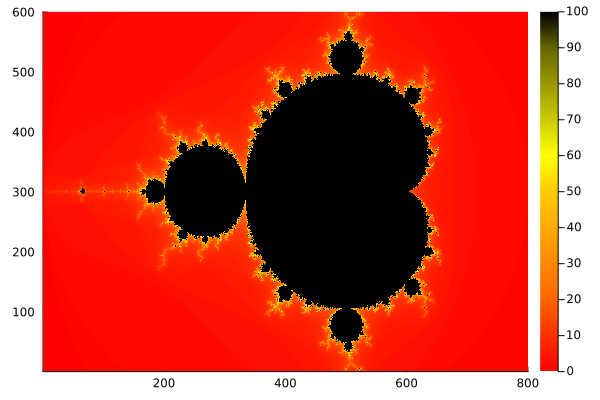

In [9]:
@btime MandelbrotSet()
pic = MandelbrotSet()
heatmap(1:size(pic,2),1:size(pic,1), pic, 
    color = cgrad([:red, :yellow, :black], [0.2, 0.5, 0.7, 0.9]))


## 2.1 Using Threads

the performance of the MandelbrotSet function can be enhanced with the use of threads.  
In the function, a thread is generated to calculate the values for all the pixels in a single column.  

after adding threads the function executes 75% faster than sequentially.  

In [10]:
function thread1_MandelbrotSet(niter=100, width=800, height=600, 
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    
    pic = Matrix{UInt8}(undef, height, width)

    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);

    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic
end

thread1_MandelbrotSet (generic function with 8 methods)

  6.485 ms (71 allocations: 477.23 KiB)


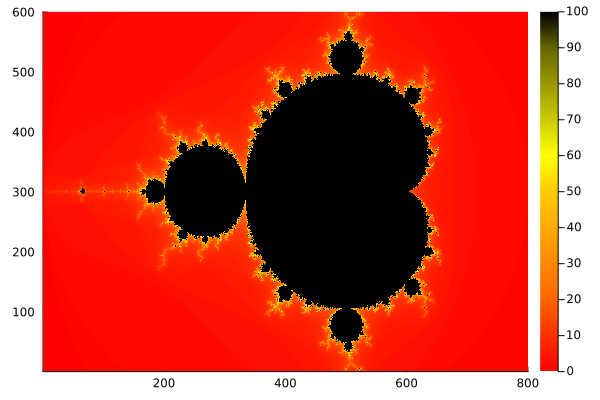

In [11]:
@btime thread1_MandelbrotSet()
pic = thread1_MandelbrotSet()
heatmap(1:size(pic,2),1:size(pic,1), pic, 
    color = cgrad([:red, :yellow, :black], [0.2, 0.5, 0.7, 0.9]))

## 2.2 Tracking Iterations in Each Thread

Now that the calculation of each column in the set is handled by a thread, the function runs much faster. However, the load is being assigned to the first available thread so the task may not be divided evenly amongst the threads.  

The threaded function has been changed to keep track of the number of pixels that each thread has to calulate over the generation of the whole set. The vector *distribution* is used to store this information. For everytime a thread calls the setMandelbrotPixel function, *distribution* is incremented at the index corresponding to the id of the current thread.

The distribution vector is displayed in a bar graph show the load balance among the threads.

In [12]:
function thread2_MandelbrotSet(niter=100, width=800, height=600, 
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    
    pic = Matrix{UInt8}(undef, height, width)
    distribution = fill(0, nthreads())

    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);

    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            distribution[threadid()] += 1
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic, distribution
end

thread2_MandelbrotSet (generic function with 8 methods)

  6.498 ms (73 allocations: 477.42 KiB)


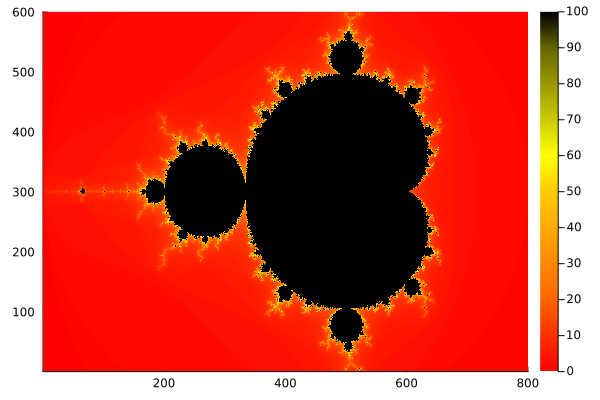

In [13]:
@btime thread2_MandelbrotSet()
pic, dis = thread2_MandelbrotSet()
heatmap(1:size(pic,2),1:size(pic,1), pic, 
    color = cgrad([:red, :yellow, :black], [0.2, 0.5, 0.7, 0.9]))

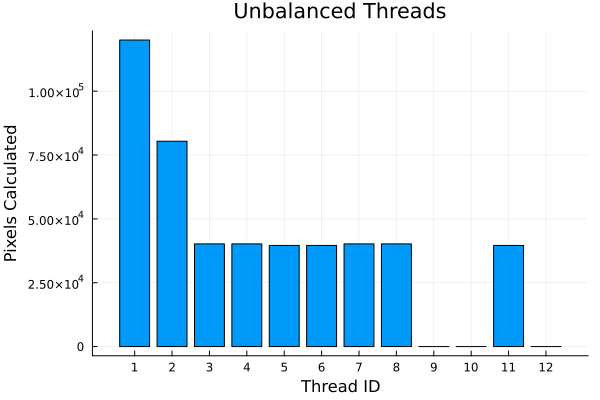

In [14]:
pic, dis = thread2_MandelbrotSet()
bar(dis, legend=false, xlabel="Thread ID", ylabel="Pixels Calculated", title="Unbalanced Threads", xticks=1:12)

The Bar Graph shows how disproportionate the execution is divided to the threads.

## 2.3 Balancing Threads

To increase efficiency even further. The ChunkSplitters package provides thread load balancing with the chunks() function.  
ChunkSplitters will divide the workload evenly across the threads before begining execution.  

In [15]:
function thread3_MandelbrotSet(niter=100, width=800, height=600, 
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    
    pic = Matrix{UInt8}(undef, height, width)
    distribution = fill(0, nthreads())

    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);

    # Compute pic column by column
    @sync for (j_range, j_chunk) in chunks(1:width, nthreads(), :scatter)
    @spawn for j in j_range
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            distribution[j_chunk] += 1
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    end 
    return pic, distribution
end

thread3_MandelbrotSet (generic function with 8 methods)

  3.409 ms (152 allocations: 479.36 KiB)


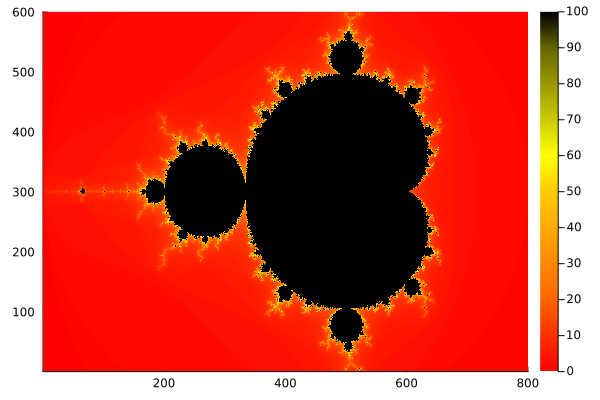

In [16]:
@btime thread3_MandelbrotSet()
pic, dis = thread3_MandelbrotSet()
heatmap(1:size(pic,2),1:size(pic,1), pic, 
    color = cgrad([:red, :yellow, :black], [0.2, 0.5, 0.7, 0.9]))

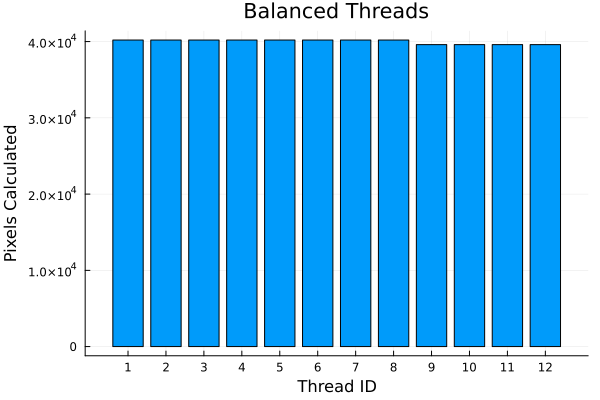

In [17]:
pic, dis = thread3_MandelbrotSet()
bar(dis, legend=false, xlabel="Thread ID", ylabel="Pixels Calculated", title="Balanced Threads", xticks=1:12)

After Balancing the workload, as shown in the bar chart, execution time compared to unbalanced threads is around 50% faster (or 80% faster than the unmodified).

## 2.4 Thread ID by pixel Heatmap

to visualize the load balancing another way, A heat map showing each pixel with a color corresponding to the thread that calculated the final madelbrot set color of that pixel.

In [18]:
function thread4_MandelbrotSet(niter=100, width=800, height=600, 
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    
    pic = Matrix{UInt8}(undef, height, width)
    pixel_id = zeros(height, width)

    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);

    # Compute pic column by column
    @sync for (j_range, j_chunk) in chunks(1:width, nthreads(), :scatter)
    @spawn for j in j_range
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            pixel_id[i,j] = j_chunk
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    end 
    return pic, pixel_id
end

thread4_MandelbrotSet (generic function with 8 methods)

  3.829 ms (152 allocations: 4.13 MiB)


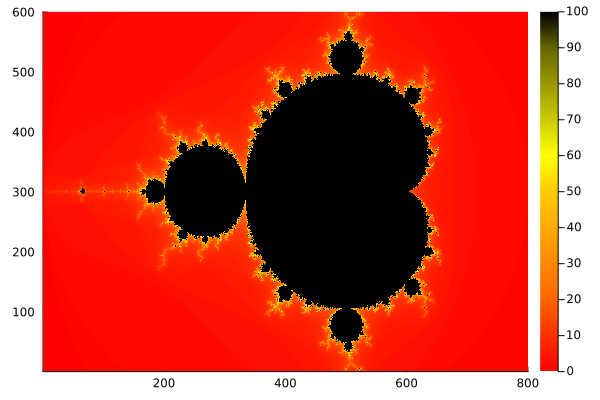

In [19]:
@btime thread4_MandelbrotSet()
pic, pid = thread4_MandelbrotSet()
heatmap(1:size(pic,2),1:size(pic,1), pic, 
    color = cgrad([:red, :yellow, :black], [0.2, 0.5, 0.7, 0.9]))

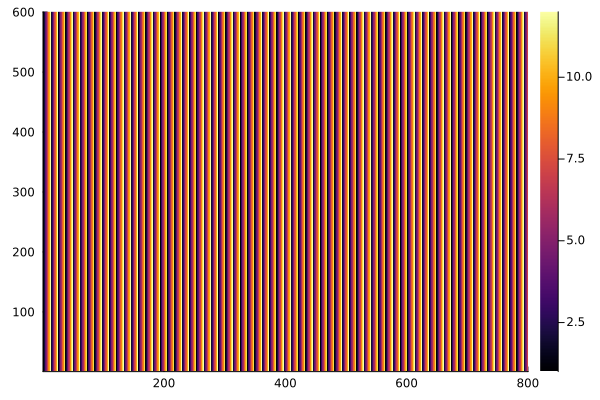

In [20]:
pic, pid = thread4_MandelbrotSet()
heatmap(1:size(pid,2),1:size(pid,1), pid)

The heatmap shows how each thread handles a column of the set. There is also a repeating pattern of colors which shows how the work load is evenly distributed.

# 3. Sum Reduction

before getting the timming results of the different methods, the 10,000,000 random numbers are pre-calculated for the sum methods so that the time to generate random numbers won't affect the timing results. With pre-generated random numbers we can also compare the results with


In [21]:
rand_num = zeros(10_000_000)
for i=1:10_000_000
    rand_num[i] = rand()
end

In [22]:
@btime begin
    seq_sum = 0
    for i=1:10_000_000
        seq_sum += rand_num[i]
    end
end
"Sequential Sum"

  333.301 ms (29999489 allocations: 457.76 MiB)


"Sequential Sum"

In [23]:
using Base.Threads
using ChunkSplitters

@btime begin
    par_sum = zeros(nthreads())
    @threads for (r,c) in chunks(1:10_000_000, nthreads())
        for i in r
            par_sum[c] += rand_num[i]
        end
    end
   +(par_sum...)
end
"Threaded Sum"


  236.951 ms (39999591 allocations: 610.35 MiB)


"Threaded Sum"

In [24]:
@btime Base.sum(rand_num)
"Base.sum Function"

  2.925 ms (1 allocation: 16 bytes)


"Base.sum Function"

In [25]:
using Folds
@btime Folds.sum(rand_num)
"Folds.sum Function"

  1.486 ms (118 allocations: 10.23 KiB)


"Folds.sum Function"

The sequential method is the slowest where no steps are taken to optimize the solution  
using threads in the solutions results are found 20% - 30% faster than the time for the sequential method
the execution times of Folds.sum and Base.sum are very similar in execution time (Folds is only slower by a hundered or so nanoseconds).
The Folds.sum and Base.sum have much lower execution times than the previous two methods, executing around 90% faster.  

Below are some sample results of the 4 methods  

5.000730085045086e6  
5.000730085045629e6  
5.000730085045574e6  
5.000730085045577e6  

the results are the same untill the 12th floating point digit. its no supprise that the Fold.sum and the Base.sum methods have the most similiar answers up untill the last floating point digit.